In [1]:
import os, shutil, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family = font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import random
import re
import json

# from urllib.request import urlopen
# from bs4 import BeautifulSoup

# 잔여영양소 계산

### 반찬추천(연관분석)

In [2]:
##### 주요 변수 정의
# unique menus 리스트 불러오기
unique_menus=[]
with open('content/uniqu_menus_list.txt', "r", encoding="euc-kr") as f:
    for line in f :
        unique_menus.append(line)
        
#반찬연관분석(코랩) 결과 불러오기
rules = pd.read_csv("content/rules2.csv", encoding="utf-8")

##### 반찬 추천 함수 
def recommend_side_dish_conviction(input_dish, top_n=10, rules=rules):
    if input_dish not in list(rules['antecedents']):
        print(f"입력한 메뉴({input_dish})가 학습 데이터에 없습니다.")

#     print(f"입력한 메뉴({input_dish})의 반찬은 다음과 같습니다.")
    recommended_dishes = rules[rules['antecedents']== input_dish].sort_values('conviction', ascending=False)[:top_n]
#     print(recommended_dishes['consequents'].tolist())
    side_menu=recommended_dishes['consequents'].tolist()

    return side_menu

##### 반찬 추천 시각화 함수
def side_visual(input_menu, rules=rules) :
    data = rules[['antecedents','consequents', 'conviction']][rules['antecedents']== input_menu]
    # data
    data_sort=data.sort_values('conviction', ascending=False).reset_index(drop=True)
    data_sort
    data_sort_top20=data_sort.loc[0:20]
    data_sort_top20

    G = nx.from_pandas_edgelist(data_sort_top20, 
                                source = 'antecedents', 
                                target = 'consequents')
    plt.figure(figsize=(10, 10)) ; plt.axis('off')
    nx.draw_kamada_kawai(G)
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='black',
                           font_family=font_name)
    nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=2000, alpha=1)
    plt.show()

### 점심+반찬 영양소 계산

In [3]:
##### 주요 변수 정의
# DF 불러우기
df_intake=pd.read_csv("content/권장섭취량(intake).csv",encoding="utf-8")
df_food=pd.read_csv("content/식품영양정보_탄단지_main(food).csv", encoding="utf-8")

# 공통변수
factors = ['에너지(kcal)','탄수화물(g)','단백질(g)', '지방(g)', '총당류(g)','나트륨(g)']
nutrient_dict={'standard':[],'lunch':[], 'side':[],'total':[], 'remain':[]}

#### 영양소 추출 함수 정의
def food_finder(input_menu, f=factors, df=df_food) :
    if type(input_menu)==list :
        find_term = df[df["식품명"].isin(input_menu)]
    else : 
        find_term=df[df["식품명"]==input_menu]
    find_idx = list(find_term.index)
    menu_nutrient=[]
    for s in find_idx:
        find_menu=[]
        for i in range(len(f)) :
            find_menu.append(find_term[f[i]][s])    
        menu_nutrient.append(find_menu)
    return menu_nutrient

#### 권장량 추출 함수 정의
def standard_finder(sex, age, f=factors, df=df_intake) :
    
    std_term = df[ (df["성별"] == sex) & (df["연령별"] == age) ]
    std_nutrient=[]
    for i in range(len(f)) :
        if f[i] == '에너지(kcal)':
            std_nutrient.append(list(set(std_term[f[i]].values.tolist()))[0])
        else : 
            std_nutrient.append(std_term['권장섭취량'][std_term["영양소"]==f[i]].values.tolist()[0])

    return std_nutrient

#### 누적 영양소 함수 정의
def total_calculator(input_menu, input_side,  n_dict=nutrient_dict, f=factors) :
    n_dict["lunch"]=food_finder(input_menu)
    n_dict["side"]=food_finder(input_side)
    
    total_nutrient=[]
    for i in range(len(f)) :
        for l in n_dict['lunch'] :
            total = l[i]
            accum = 0
            for s in n_dict['side'] :
                accum = accum + s[i]
        total_nutrient.append(total+accum)
    return total_nutrient

##### 잔여 영양소 함수 정의
def remain_calculator(sex, age, input_menu, input_side,  n_dict=nutrient_dict, f=factors) :
    n_dict["standard"]= standard_finder(sex, age)
    n_dict["total"]= total_calculator(input_menu, input_side)
    
    # 잔여 영양소 계산
    remain_nutrient=[]
    for i in range(len(f)) :
        remain_nutrient.append(n_dict['standard'][i]-n_dict['total'][i])

    return remain_nutrient

##### 전체 딕트 정의 함수
def nutrient_calculator(sex, age, input_menu, input_side, n_dict=nutrient_dict, f=factors) :
    n_dict['remain']=remain_calculator(sex, age, input_menu, input_side)

    return n_dict    

##### 출력 함수
def nutrient_output(f=factors, n_dict=nutrient_dict) :
    col =['lunch','side','total','standard','remain']
    for i in col :
        val=n_dict[i]
#         print(val)
        print('{} ===================================='.format(i))
        if i in ['lunch','side'] :
            for j in range(len(f)) :
                num=[]
                for k in range(len(val)) :                 
                    num.append(val[k][j])
                print(' - {} : {}'.format(f[j], np.round(num, 2)))
        else :    
            for j in range(len(f)) :
                print(' - {} : {}'.format(f[j], np.round(val[j], 2)))

# 시뮬레이션

user는 12-14세의 여자입니다.
점심메뉴는 순대국밥이며, 추천반찬은['부추무침,김치전', '메밀전병', '도토리묵무침']입니다.
lunch ====================================
 - 에너지(kcal) : [673.09]
 - 탄수화물(g) : [93.46]
 - 단백질(g) : [28.56]
 - 지방(g) : [20.56]
 - 총당류(g) : [1.51]
 - 나트륨(g) : [1.14]
side ====================================
 - 에너지(kcal) : [167.83]
 - 탄수화물(g) : [21.62]
 - 단백질(g) : [6.18]
 - 지방(g) : [6.29]
 - 총당류(g) : [0.62]
 - 나트륨(g) : [0.35]
total ====================================
 - 에너지(kcal) : 840.92
 - 탄수화물(g) : 115.08
 - 단백질(g) : 34.74
 - 지방(g) : 26.85
 - 총당류(g) : 2.13
 - 나트륨(g) : 1.48
standard ====================================
 - 에너지(kcal) : 2000.0
 - 탄수화물(g) : 130.0
 - 단백질(g) : 55.0
 - 지방(g) : 66.67
 - 총당류(g) : 50.0
 - 나트륨(g) : 2.0
remain ====================================
 - 에너지(kcal) : 1159.08
 - 탄수화물(g) : 14.92
 - 단백질(g) : 20.26
 - 지방(g) : 39.82
 - 총당류(g) : 47.87
 - 나트륨(g) : 0.52


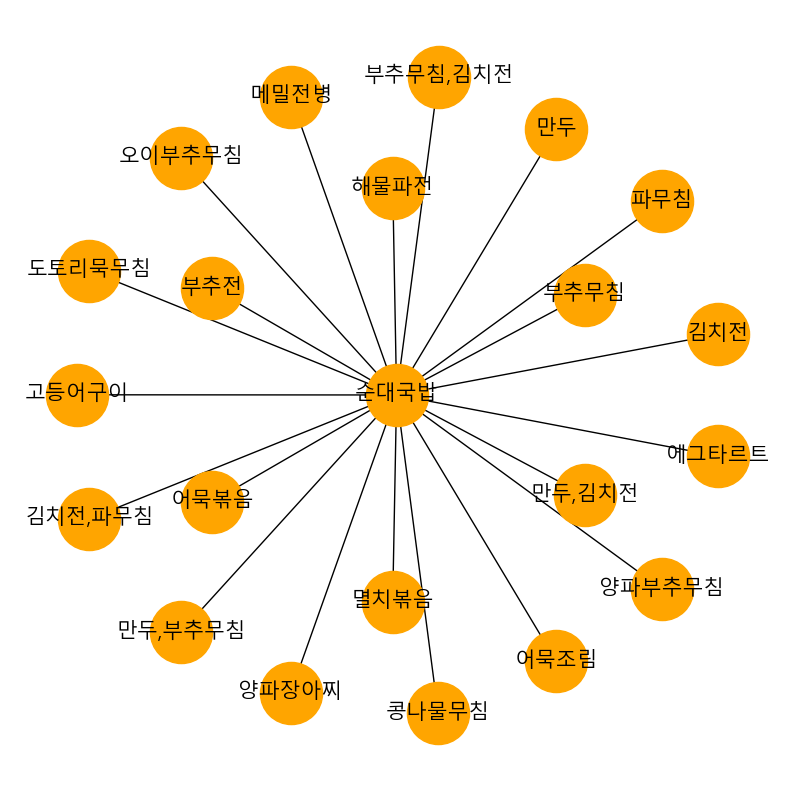

[1159.08, 14.920000000000002, 20.260000000000005, 39.81666666666668, 47.87, 0.5166200000000001]


In [6]:
##### data input
sex = '여자'
age = '12-14'
lunch= '순대국밥'

# side_cat = recommend_side_dish_conviction(lunch)
side = ['부추무침,김치전', '도토리묵무침', '메밀전병']
# print(side_menu)
print('user는 {}세의 {}입니다.'.format(age, sex))
print("점심메뉴는 {}이며, 추천반찬은{}입니다.".format(lunch, side))

##### 함수
nutrient_calculator(sex, age, lunch, side)

##### 결과
nutrient_output()

##### 시각화
side_visual(lunch)

remain=nutrient_dict['remain']
print(remain)